In [4]:
import warnings
import sys 
import os    
import glob
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
from scipy.stats import norm

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import nilearn as nl
from nilearn import plotting, image, datasets
smallsize=14; mediumsize=16; largesize=18
plt.rc('xtick', labelsize=smallsize); plt.rc('ytick', labelsize=smallsize); plt.rc('legend', fontsize=mediumsize)
plt.rc('figure', titlesize=largesize); plt.rc('axes', labelsize=mediumsize); plt.rc('axes', titlesize=mediumsize)
from pathlib import Path
output_dir = Path.cwd() / "images" 
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

In [5]:
from nilearn import datasets
print(f"Datasets are stored in: {datasets.get_data_dirs()!r}")

Datasets are stored in: ['C:\\Users\\izika/nilearn_data']


(61, 73, 61, 523)
(61, 73, 61)


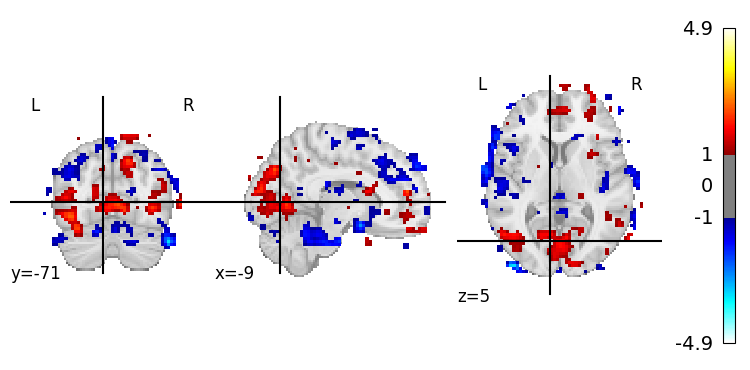

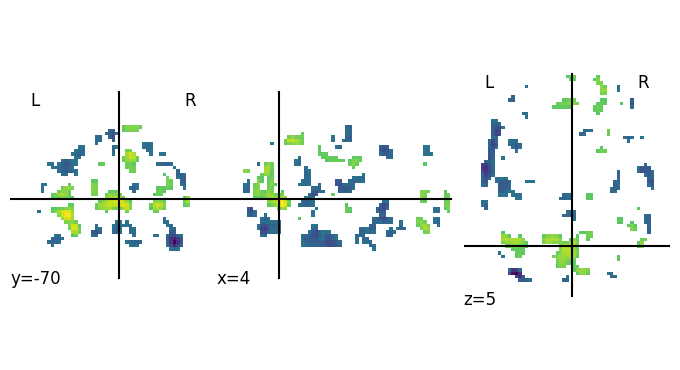

In [41]:
file = r'C:\Users\izika\OneDrive\Documents\ComDePri\Memory\fMRI data Project\RecallFiles_published\recall_files\sherlock_recall_s1.nii'
print(image.load_img(file).shape)
first_TR = image.index_img(file, 0)
print(first_TR.shape)

plotting.plot_stat_map(first_TR, threshold=1)#, output_file=output_dir / "first_TR.png")
plotting.plot_img(image.smooth_img(first_TR, fwhm=3), threshold=1)
# first_TR.to_filename(output_dir / "first_TR.nii.gz")

In [33]:
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

# The first label correspond to the background
print(f"The atlas contains {len(atlas.labels) - 1} non-overlapping regions")


Added README.md to C:\Users\izika/nilearn_data


Dataset created in C:\Users\izika/nilearn_data\fsl



Downloaded 24813568 of 25716861 bytes (96.5%,    0.3s remaining) ...done. (8 seconds, 0 min)
Extracting data from C:\Users\izika/nilearn_data\fsl\3d1b1ab2f8482efeb836414d829dc205\HarvardOxford.tgz...

The atlas contains 48 non-overlapping regions


.. done.


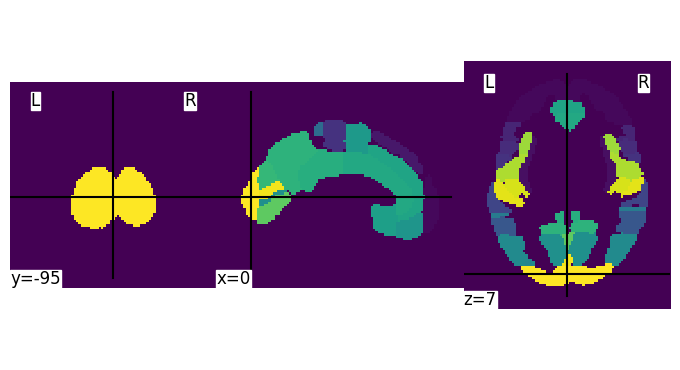

In [67]:
plotting.plot_img(atlas.maps)

In [51]:
from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas.maps, labels=atlas.labels, standardize=True)
masker.fit(first_TR)
masker.mask_img_

In [46]:
signal = masker.transform(file)
signal

array([[ 0.15169421,  0.64014184, -0.7867715 , ..., -0.4547277 ,
         1.0073842 , -0.07209162],
       [ 0.1992178 ,  0.3555848 ,  0.37679705, ...,  1.8877627 ,
         2.8578486 ,  1.0121639 ],
       [ 1.1527618 ,  1.9056267 ,  1.6437868 , ...,  2.6175942 ,
         0.98427725,  1.6237044 ],
       ...,
       [ 0.9736829 ,  2.1223662 ,  1.258064  , ...,  1.2626466 ,
         0.66085637,  0.883106  ],
       [ 0.34806153,  0.45593575,  0.4541106 , ...,  0.38634232,
         1.6180134 ,  0.916803  ],
       [-0.4120385 , -0.68966633, -0.34337872, ..., -1.4797119 ,
        -0.13928278,  0.3011756 ]], dtype=float32)